In [346]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from pylab import meshgrid
import math
import random
import scipy.optimize as opt

TOURNAMENT_SIZE = 2




def f1(x1, y1):
    return (x1**2 + y1 - 11)**2 + (x1 + y1**2 - 7)**2

def f2(x2, y2):
    return 2*x2**2 + 1.05*x2**4 + (x2**6)/6 + x2*y2 + y2**2


def function_wrapper_for_opt(f):
    def wrapped_f(x):
        return f(*x)
    return wrapped_f

In [347]:
def find_minimas(f, x_bounds, y_bounds):
    x = np.linspace(x_bounds[0], x_bounds[1], 10)
    y = np.linspace(y_bounds[0], y_bounds[1], 10)
    linespace_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    mins = []
    for point in linespace_grid:
        minimum = opt.minimize(function_wrapper_for_opt(f), point, bounds=[x_bounds, y_bounds])
        minimum = (round(minimum.x[0], 2), round(minimum.x[1], 2), round(minimum.fun, 2))
        mins.append(minimum)
    mins = set(mins)
    mins = sorted(mins, key=lambda x: x[2])
    return mins

In [348]:
def draw_plot_3d(function):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)

    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    fig.suptitle('Funkcje celu', fontsize=20)
    ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('f1(x, y)', fontsize=16)
    ax1.grid(True)

    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, 50, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('f1(x, y)' + " - Contours (Top view)")

    mins = find_minimas(function, [-5, 5], [-5, 5])
    if mins:
        global_min = mins[0]
        ax2.plot(global_min[0], global_min[1], 'g.', markersize=12, label=f"Global min (Z = {global_min[2]})")
        local_mins = mins[1:]
        for local_min in local_mins:
            ax2.plot(local_min[0], local_min[1], 'r.', markersize=12, label=f"Local min (Z = {local_min[2]})")

    ax2.legend()
    plt.tight_layout()
    plt.show()

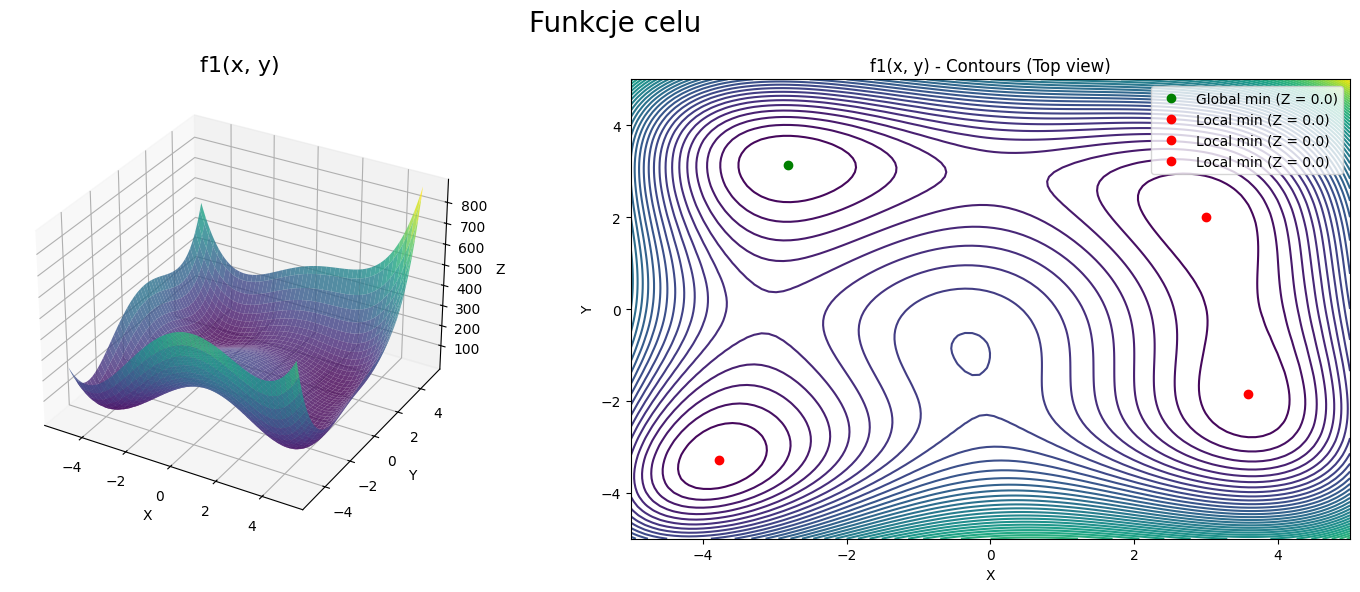

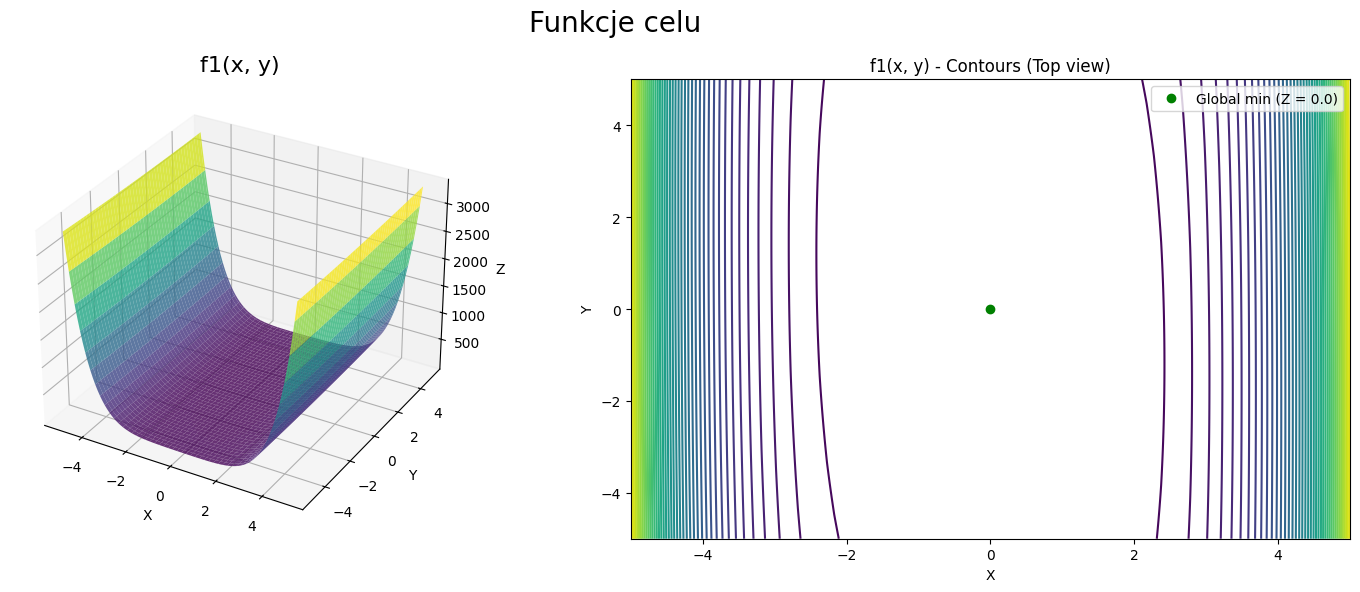

In [349]:
draw_plot_3d(f1)
draw_plot_3d(f2)

Jak widać f2 zbiega do jednego minimum globalnego znajdującego się w 0, więc jest prosta.
<br/>
Natomiast f1 posiada 4 minima lokalne, z czego każde z nich wynosi 0, więc za każdym razem będziemy zbiegać do jednego z nich.

<h4>Minima obu funkcji są 0, więc wartości sumy w okolicach 0 będą przyjmowane jako dobre.</h4>

In [350]:
class Individual:
    def __init__(self, normal_dist=False):
        self.value = None
        self.chromosome = [0, 0, 0, 0]

        if normal_dist:
            self.initialize_normal_dist_chromosome()
        else:
            self.initialize_random_chromosome()

    def initialize_random_chromosome(self):
        self.chromosome = [random.uniform(-5, 5) for _ in range(4)]

    def initialize_normal_dist_chromosome(self):
        x_starter = -0.3
        y_starter = -0.9
        self.chromosome[0] = np.random.normal(x_starter)
        self.chromosome[1] = np.random.normal(y_starter)
        self.chromosome[2] = np.random.normal(-5, 5)
        self.chromosome[3] = np.random.normal(-5, 5)

    def mutate_chromosome_part(self, index, mutation):
        self.chromosome[index] += mutation

    def get_chromosome(self):
        return self.chromosome

    def get_value(self):
        return self.value

    def set_chromosome_values(self, new_chromosome):
        self.chromosome = new_chromosome

    def set_value(self, value):
        self.value = value

    def __str__(self) -> str:
        return f"Individual: {self.chromosome}, Value: {self.value}"


def fitness_function(individual: Individual):
    x1, y1, x2, y2 = individual.get_chromosome()
    result = f1(x1, y1) + f2(x2, y2)
    return result

In [351]:
class Population:
    def __init__(self, population_size, normal_dist=False):
        self.population_size = population_size
        self.individuals = []
        self.best_individual = None
        self.initialize_population(normal_dist)

    def initialize_population(self, normal_dist):
        for _ in range(self.population_size):
            self.individuals.append(Individual(normal_dist))

    def calculate_population_values(self):
        for individual in self.individuals:
            individual.set_value(fitness_function(individual))
        self.individuals = sorted(self.individuals, key=lambda individual: individual.value)

    def find_best_individual(self):
        self.best_individual = min(self.individuals, key=lambda individual: individual.value)

    def __str__(self):
        result = ""
        for individual in self.individuals:
            result += str(individual) + "\n"
        return result

In [368]:
def draw_population_plot(population, plot_title):
    x = np.linspace(-7, 7, 100)
    y = np.linspace(-7, 7, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = f1(X, Y)


    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(121)

    fig.suptitle(plot_title, fontsize=20)
    contour1 = ax1.contour(X, Y, Z1, 60, cmap='viridis')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('f1(x, y) - Colored Contours (Top view)')


    mins1 = find_minimas(f1, (-5, 5), (-5, 5))
    if mins1:
        global_min1 = mins1[0]
        ax1.plot(global_min1[0], global_min1[1], 'r.', markersize=10, label=f"Global min (Z = {global_min1[2]})")
        local_mins1 = mins1[1:]
        for local_min1 in local_mins1:
            ax1.plot(local_min1[0], local_min1[1], 'g.', markersize=10, label=f"Local min (Z = {local_min1[2]}")

    ax1.legend()

    plt.tight_layout()
    x1 = [individual.get_chromosome()[0] for individual in population.individuals]
    y1 = [individual.get_chromosome()[1] for individual in population.individuals]

    ax1.scatter(x1, y1, marker='o', s=30, c='b', label=f'Last generation')
    ax1.legend()

    plt.show()

In [369]:
class GeneticAlgorithm:
    def __init__(
        self,
        function,
        population: Population,
        generations,
        mutation_rate,
        mutation_range,
        crossover_rate,
    ):
        self.function = function
        self.population = population
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.crossover_rate = crossover_rate
        self.best_individual = None

    def tournament_selection(self):
        new_generation = []
        for _ in (self.population.individuals):
            tournament = random.sample(range(len(self.population.individuals)), TOURNAMENT_SIZE)
            best_individual = min(tournament, key=lambda i: self.population.individuals[i].get_value())
            new_generation.append(self.population.individuals[best_individual])
        self.population.individuals = new_generation

    def gaussian_mutation(self):
        for individual in self.population.individuals:
            for i in range(len(individual.get_chromosome())):
                if random.uniform(0, 1) < self.mutation_rate:
                    individual.mutate_chromosome_part(i, np.random.normal(0, self.mutation_range))

    def crossover(self):
        new_generation = []
        for entity in self.population.individuals:
            if np.random.uniform(0, 1) < self.crossover_rate:
                partner = np.random.choice(self.population.individuals)
                crossover_point = np.random.randint(1, len(entity.get_chromosome()))
                child = Individual()
                child_chromosome = entity.get_chromosome()[:crossover_point] + partner.get_chromosome()[crossover_point:]
                child.set_chromosome_values(child_chromosome)
                new_generation.append(child)
            else:
                new_generation.append(entity)
        self.population.individuals = new_generation

        self.population.individuals = new_generation

    def run_algorithm(self, display_plot=False, plot_title=""):
        self.population.calculate_population_values()
        self.population.find_best_individual()
        self.best_individual = self.population.best_individual
        for _ in range(1, int(self.generations)):
            self.tournament_selection()
            self.gaussian_mutation()
            self.crossover()
            self.population.calculate_population_values()
            self.population.find_best_individual()
            if (self.population.best_individual.get_value() < self.best_individual.get_value()):
                self.best_individual = self.population.best_individual
        if(display_plot):
            draw_population_plot(self.population, plot_title)
        return self.best_individual

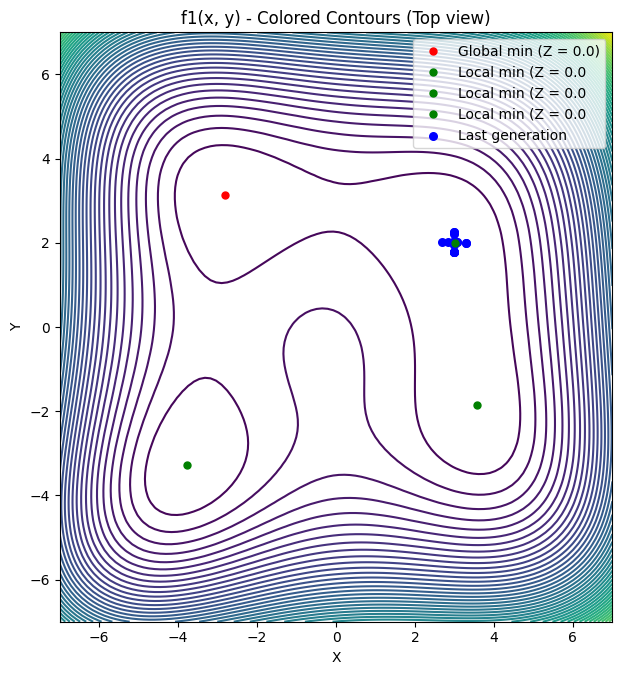

Best Individual:
Individual: [2.9959594687620954, 2.011540361720114, -0.003128317711915407, 0.0017591769450856776], Value: 0.001963520154879062
Last population:
Individual: [2.9976995669178392, 2.011540361720114, -0.0061619253485423325, -0.005468992547310446], Value: 0.002080132448239181
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.00846649001789114], Value: 0.0023028716600223156
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.00846649001789114], Value: 0.0023028716600223156
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.00846649001789114], Value: 0.0023028716600223156
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.005468992547310446], Value: 0.0023041271514718234
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.005468992547310446], Value: 0.0023041271514718234
Individual: [2.9976995669178392, 2.011540361720114, 0.014354329106968513, -0.00

In [370]:
generations = 400
mutation_rate = 0.05
mutation_range = 0.3
crossover_rate = 0.85
population_size = 45
start_population = Population(population_size)
algorthm = GeneticAlgorithm(fitness_function, start_population, generations, mutation_rate, mutation_range, crossover_rate)
best_entity = algorthm.run_algorithm(True)
print("Best Individual:")
print(best_entity)
print("Last population:")
print(algorthm.population)

# Wybór dobrych hiperparametrów

Z moich obserwacji wynika że całkiem dobrymi parametrami, wystarczającymi by całkiem dokładnie oszacować wyniki są:
- generations = 400
- population_size = 45
- crossover_rate = 0.885
- mutation_rate = 0.05
- mutation_range = 0.3

In [355]:
def run_algorithm_with_distribution(is_normal_dist, hyperparameters, key, value, return_point=False):
    number_of_runs = 5
    entity_values = []
    for _ in range(number_of_runs):
        hyperparameters[key] = value
        start_population = Population(hyperparameters['population_size'], is_normal_dist)
        algorithm = GeneticAlgorithm(fitness_function,
                                    start_population,
                                    hyperparameters['generations'],
                                    hyperparameters['mutation_rate'],
                                    hyperparameters['mutation_range'],
                                    hyperparameters['crossover_rate'])
        best_entity = algorithm.run_algorithm()
        entity_values.append(best_entity.get_value())
    average_value = sum(entity_values) / number_of_runs
    if(return_point):
        return best_entity.get_chromosome()
    return average_value

<h3>Wpływ dystrybucji populacji początkowej na współrzędne minimów funkcji f1:</h3>

Ze względu na to że wartości x1=-0.3 i y1=-0.9 znajdują się mniej więcej w tej samej odległości od wszystkich 4 minimów funkcji f1, to w zależności od tego czy populacja początkowa będzie się znajdować bliżej jednego z minimów, czy też będzie rozłożona równomiernie, to algorytm będzie zbiegał do innego minimum.
Więc czy populacja początkowa będzie rozłożona losowo czy rozkładem normalnem nie ma większego znaczenia, ponieważ w obu przypadkach algorytm będzie zbiegał do różnych minimów.

Miało by to znaczenie gdyby dla rozkładu normalnego wartości x1 i y1 byłyby bliżej jednego z minimów wtedy algorytm zbiegałby do tego minimum za każdym razem.

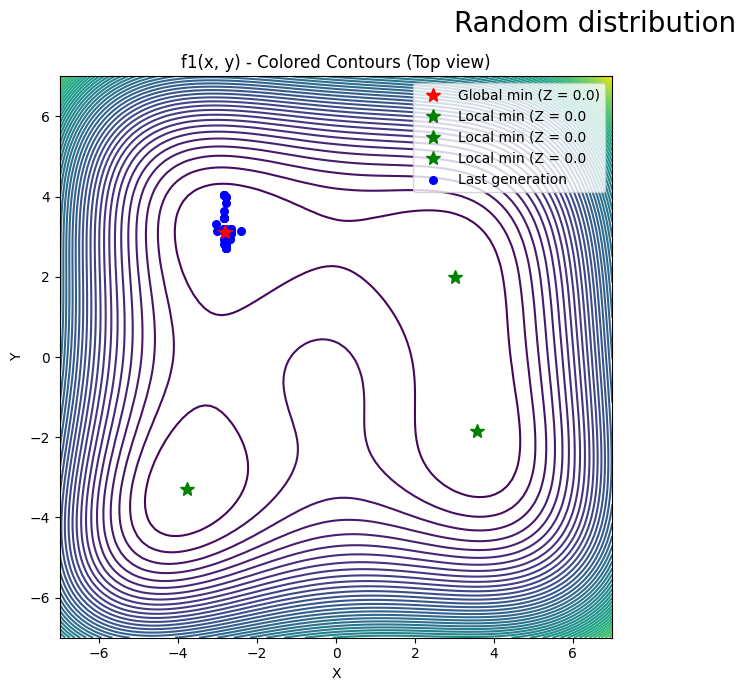

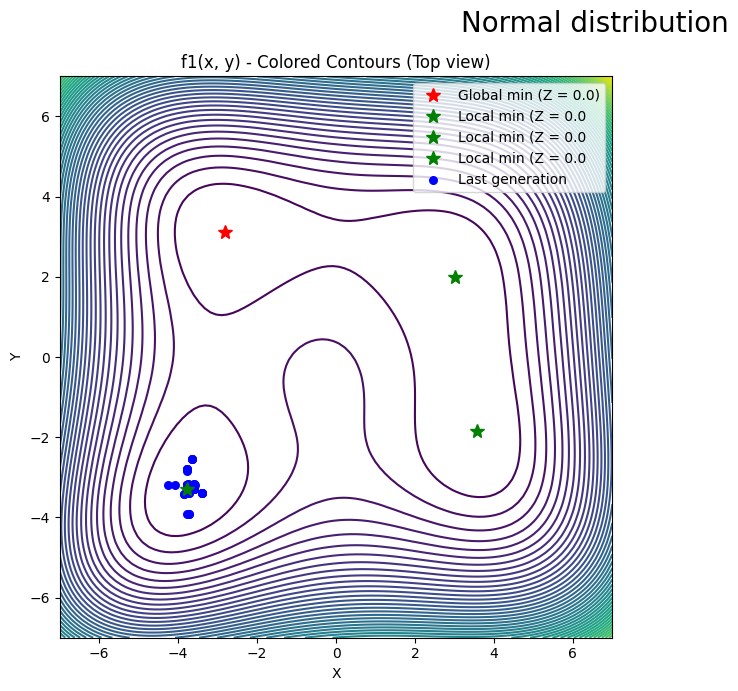

In [356]:
start_population = Population(population_size)
algorthm = GeneticAlgorithm(fitness_function, start_population, generations, mutation_rate, mutation_range, crossover_rate)
best_entity = algorthm.run_algorithm(True, "Random distribution")
start_population = Population(population_size, True)
algorthm = GeneticAlgorithm(fitness_function, start_population, generations, mutation_rate, mutation_range, crossover_rate)
best_entity = algorthm.run_algorithm(True, "Normal distribution")

# Wykresy wydajności algorytmu dla różnych parametrów

In [357]:
def draw_performance_graphs():
    generations = 400
    mutation_rate = 0.05
    mutation_range = 0.3
    crossover_rate = 0.85
    population_size = 45

    hyperparameters = {
        'generations': generations,
        'mutation_rate': mutation_rate,
        'mutation_range': mutation_range,
        'crossover_rate': crossover_rate,
        'population_size': population_size
    }

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()

    x1 = np.linspace(20, 500, 10)
    y1_normal = [run_algorithm_with_distribution(True, hyperparameters, 'generations', x) for x in x1]
    y1_random = [run_algorithm_with_distribution(False, hyperparameters, 'generations', x) for x in x1]
    hyperparameters['generations'] = generations

    axs[0].plot(x1, y1_normal, label='Normal Distribution', color='blue')
    axs[0].plot(x1, y1_random, label='Random Distribution', color='orange')
    axs[0].set_xlabel('Generations')
    axs[0].set_ylabel('Value')
    axs[0].set_title('Generations performance graph')
    axs[0].legend()

    x2 = np.linspace(0.01, 1, 10)
    y2_normal = [run_algorithm_with_distribution(True, hyperparameters, 'mutation_rate', x) for x in x2]
    y2_random = [run_algorithm_with_distribution(False, hyperparameters, 'mutation_rate', x) for x in x2]
    hyperparameters['mutation_rate'] = mutation_rate

    axs[1].plot(x2, y2_normal, label='Normal Distribution', color='blue')
    axs[1].plot(x2, y2_random, label='Random Distribution', color='orange')
    axs[1].set_xlabel('Mutation rate')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Mutation rate performance graph')
    axs[1].legend()

    x3 = np.linspace(0.1, 3, 10)
    y3_normal = [run_algorithm_with_distribution(True, hyperparameters, 'mutation_range', x) for x in x2]
    y3_random = [run_algorithm_with_distribution(False, hyperparameters, 'mutation_range', x) for x in x2]
    hyperparameters['mutation_range'] = mutation_range

    axs[2].plot(x3, y3_normal, label='Normal Distribution', color='blue')
    axs[2].plot(x3, y3_random, label='Random Distribution', color='orange')
    axs[2].set_xlabel('Mutation range')
    axs[2].set_ylabel('Value')
    axs[2].set_title('Mutation range performance graph')
    axs[2].legend()

    x4 = np.linspace(0.8, 0.95, 10)
    y4_normal = [run_algorithm_with_distribution(True, hyperparameters, 'crossover_rate', x) for x in x4]
    y4_random = [run_algorithm_with_distribution(False, hyperparameters, 'crossover_rate', x) for x in x4]
    hyperparameters['crossover_rate'] = crossover_rate

    axs[3].plot(x4, y4_normal, label='Normal Distribution', color='blue')
    axs[3].plot(x4, y4_random, label='Random Distribution', color='orange')
    axs[3].set_xlabel('Crossover rate')
    axs[3].set_ylabel('Value')
    axs[3].set_title('Crossover rate performance graph')
    axs[3].legend()

    x5 = np.linspace(10, 60, 10)
    x5 = x5.astype(int)
    y5_normal = [run_algorithm_with_distribution(True, hyperparameters, 'population_size', x) for x in x5]
    y5_random = [run_algorithm_with_distribution(False, hyperparameters, 'population_size', x) for x in x5]
    hyperparameters['population_size'] = population_size

    axs[4].plot(x5, y5_normal, label='Normal Distribution', color='blue')
    axs[4].plot(x5, y5_random, label='Random Distribution', color='orange')
    axs[4].set_xlabel('Population size')
    axs[4].set_ylabel('Value')
    axs[4].set_title('Population size performance graph')
    axs[4].legend()

    plt.tight_layout()
    plt.show()

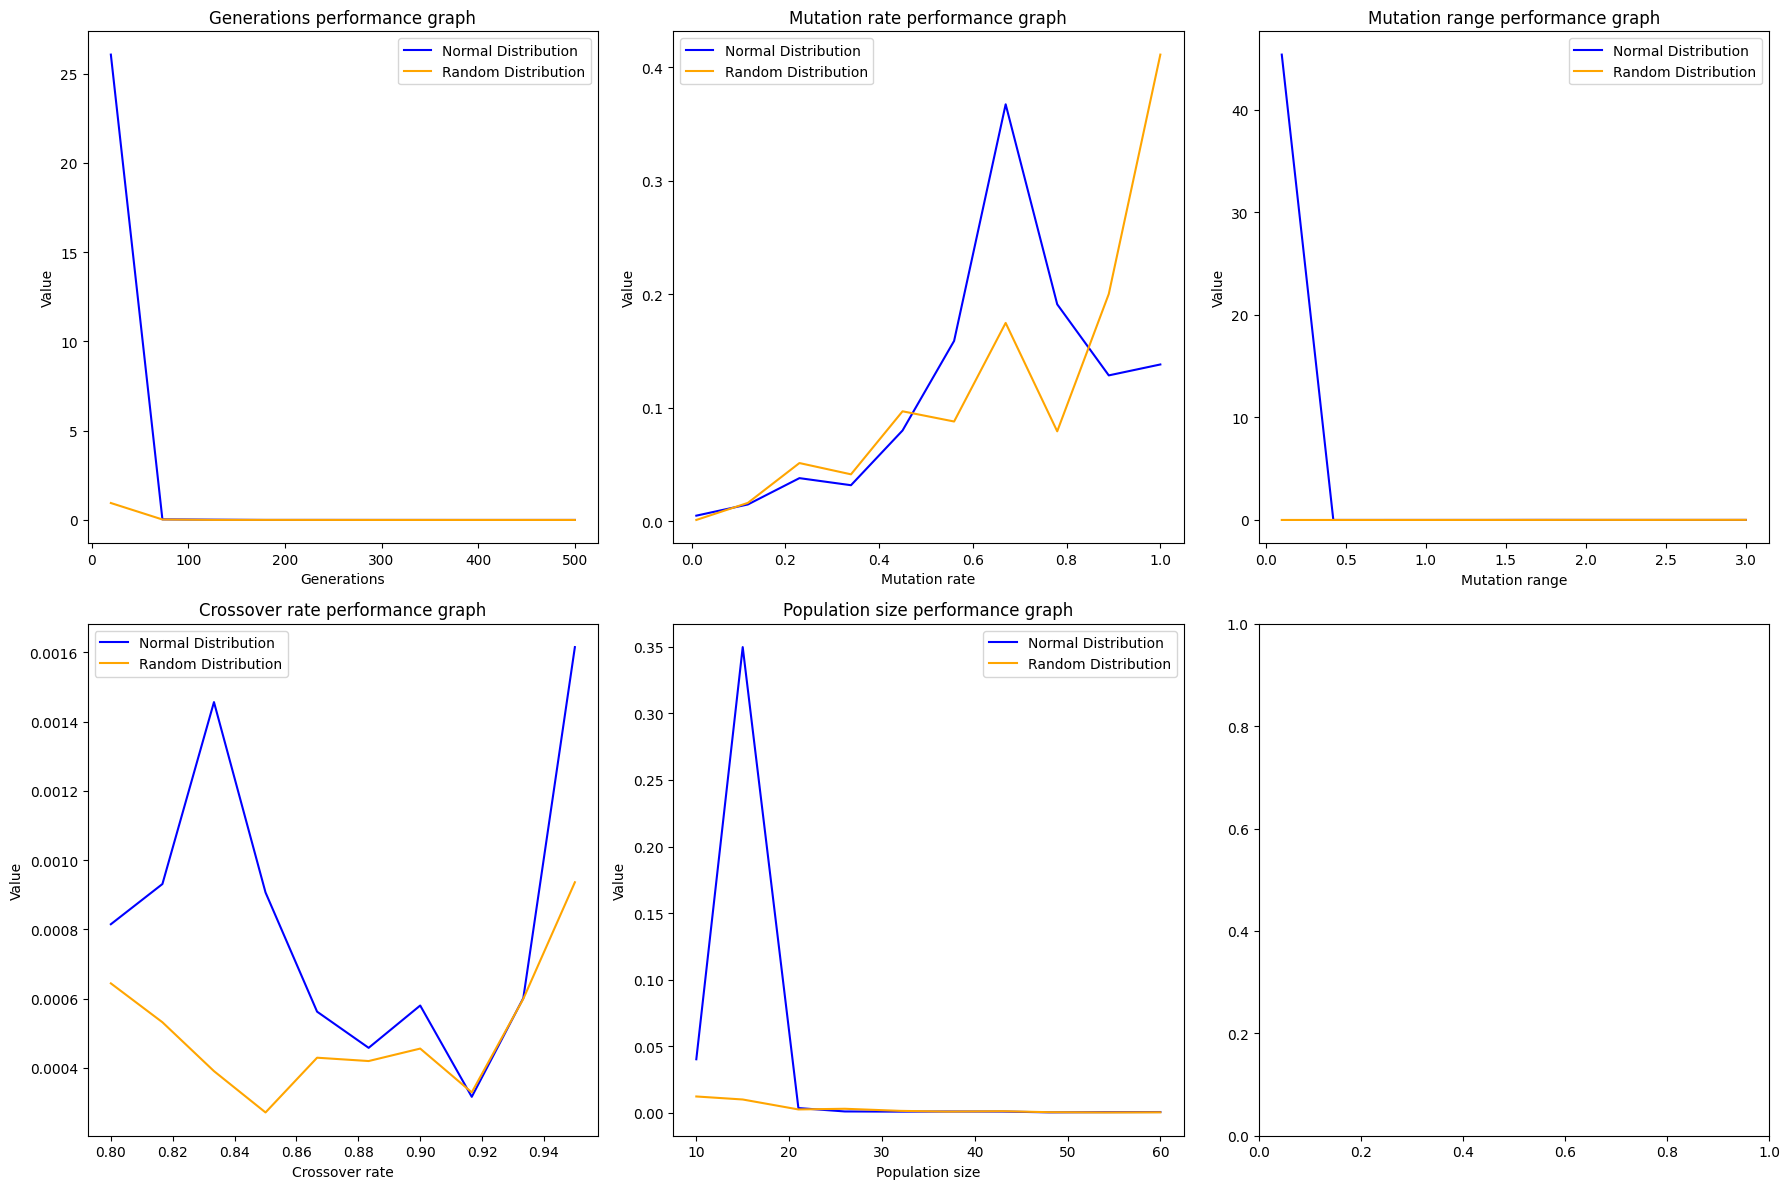

In [358]:
draw_performance_graphs()

<h3>Wpływ współczynnika krzyżowania i mutacji na współrzedne minimów funkcji f1:</h3>

In [359]:
# Obliczam do ktorego minimum zbiega punkt
def calculate_which_minima(point, minimas: list):
    minima_index = None
    distance = 100000000
    for minimum in minimas:
        new_distance = math.sqrt((point[0] - minimum[0])**2 + (point[1] - minimum[1])**2)
        if(new_distance < distance):
            distance = new_distance
            minima_index = minimas.index(minimum)
    return minima_index

In [360]:
def calculate_distribution(key, values):
    generations = 400
    mutation_rate = 0.1
    mutation_range = 0.3
    crossover_rate = 0.85
    population_size = 60

    hyperparameters = {
        "generations": generations,
        "mutation_rate": mutation_rate,
        "mutation_range": mutation_range,
        "crossover_rate": crossover_rate,
        "population_size": population_size,
    }


    # Znajduje najlepsze osobnika dla różnych wartości parametru
    values_and_points = []
    for value in values:
        minimum = run_algorithm_with_distribution(
            False, hyperparameters, key, value, True
        )
        values_and_points.append({"mutation": value, "points": minimum, "minima_index": None})


    # Obliczam dla każdego punktu, który minimów jest najbliżej
    mins = find_minimas(f1, (-5, 5), (-5, 5))
    for value_and_point in values_and_points:
        value_and_point["minima_index"] = calculate_which_minima(value_and_point["points"], mins)


    return values_and_points

In [361]:
# Tworzy wykresy dla roznych parametrow i pokazuje do ktorego minimum zbiega dla danej wartosci parametru
def draw_distribution_plot():
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    axs = axs.ravel()

    mins = find_minimas(f1, (-5, 5), (-5, 5))
    title = ""
    for index, minimum in enumerate(mins):
        title += f"Minima {index}: {minimum}\n"
    fig.suptitle(f'Possible points:\n {title}', fontsize=20)

    # Tworze wykres dla różnych wartości mutacji
    mutation_rates = np.linspace(0.01, 3, 20)
    y1 = [int(value["minima_index"])  for value in calculate_distribution("mutation_rate", mutation_rates)]
    for i in range(len(y1)):
        axs[0].plot(mutation_rates[i], y1[i], 'r.', markersize=10)
    axs[0].set_xlabel('Mutation rate')
    axs[0].set_ylabel('Minima index')
    axs[0].set_title('Mutation performance graph')
    axs[0].legend()


    # Tworze wykres dla różnych prawdopodobieństw krzyżowania
    crossover_rates = np.linspace(0.8, 0.95, 10)
    y1 = [value["minima_index"]  for value in calculate_distribution("crossover_rate", crossover_rates)]
    for i in range(len(y1)):
        axs[1].plot(crossover_rates[i], y1[i], 'r.', markersize=10)
    axs[1].set_xlabel('Crossover rate')
    axs[1].set_ylabel('Minima index')
    axs[1].set_title('Crossover performance graph')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

<h3>Wpływ współczynnika mutacji i współczynika krzyżowania na współrzędne minimów f1</h3>

Po obejrzeniu poniższych wykresów można zauważyć że ani współczynnik mutacji ani krzyżowania nie wpływa na współrzędne minimów funkcji f1.
Jedynym co tak naprawdę wpływa na to do którego minimum funkcja będzie zbiegała jest rozłożenie populacji początkowej.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


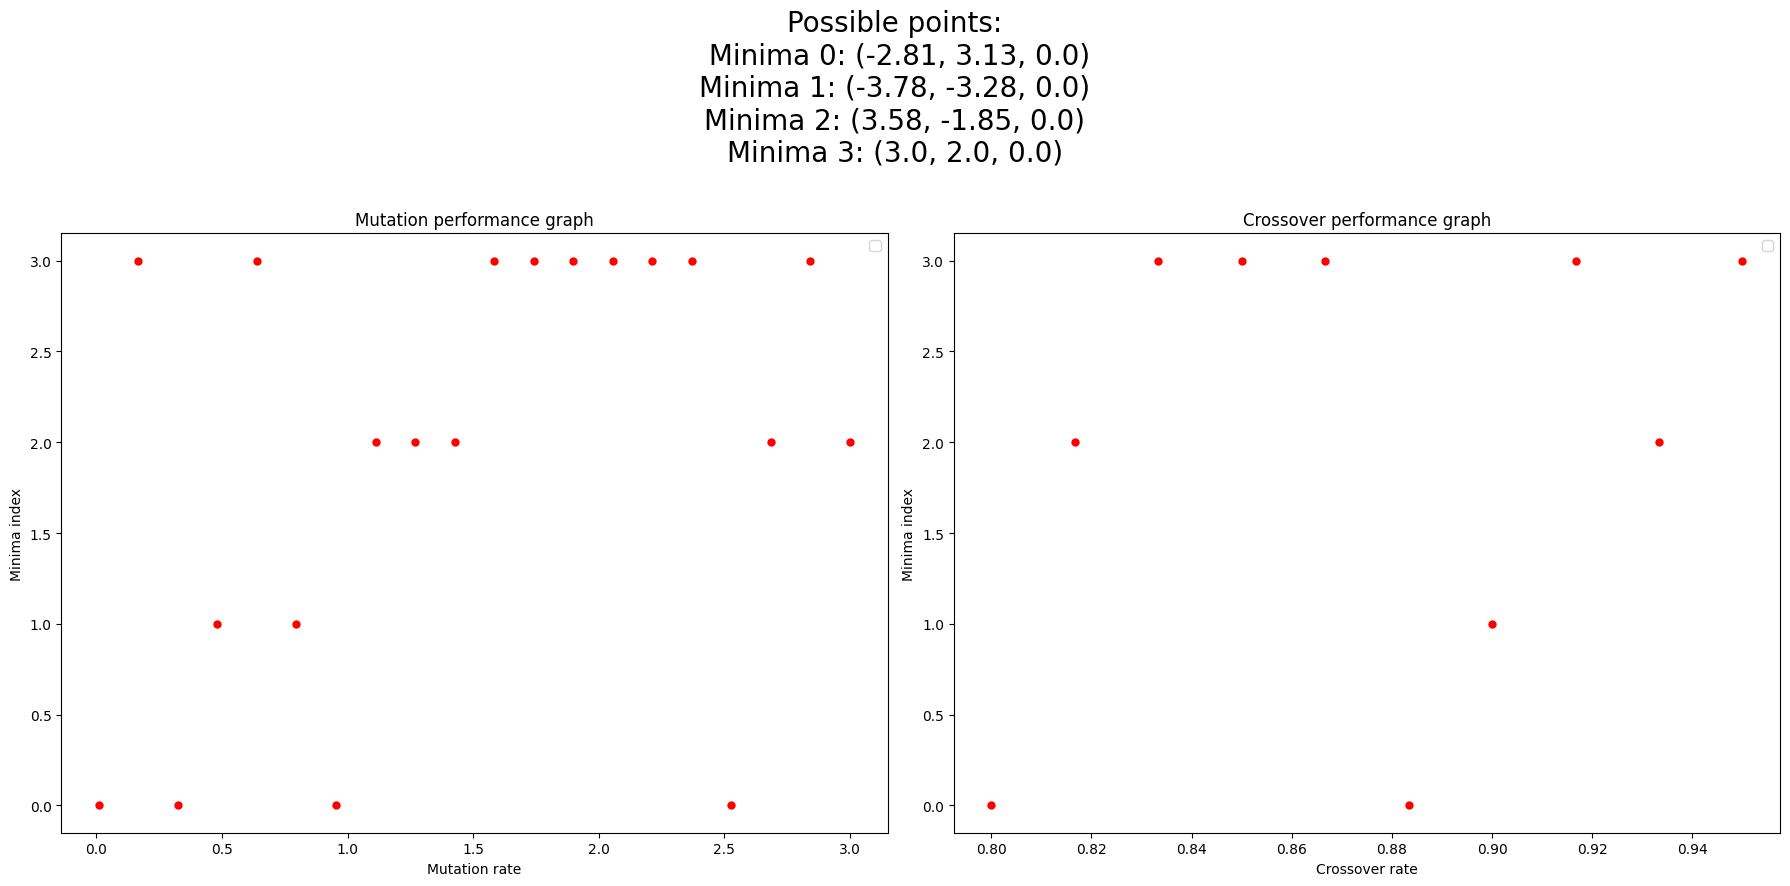

In [362]:
draw_distribution_plot()